# Das Hadeler Problem

\begin{gather*}
    T(z) = (e^z - 1) B_1 + z^2 B_2 - B_0 \\
    B_0 = b_0 I_{n\times n},
    \quad
    B_1 = (b_{j k}^{(1)}),
    \quad
    B_2 = (b_{j k}^{(2)}) \\
    b_{j k}^{(1)} = (n + 1 - \max(j, k)) j k,
    \quad
    b_{j k}^{(2)} = n \delta_{j k} + 1 / (j + k),
    \quad
    j, k = 1, \dots, n,
\end{gather*}

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import linalg
from outsource import *

## Parameter

In [2]:
n = 200
b_0 = 100

In [3]:
b_1 = lambda j, k: (n + 1 - max(j, k)) * j * k
b_2 = lambda j, k: n * int(j == k) + 1 / (j + k)

B_0 = b_0 * np.eye(n)
B_1 = np.array([[b_1(j+1, k+1) for k in range(n)] for j in range(n)])
B_2 = np.array([[b_2(j+1, k+1) for k in range(n)] for j in range(n)])

T = lambda z: (np.exp(z) - 1) * B_1 + z ** 2 * B_2 - B_0

In [4]:
N = n

## Globaler Testlauf

Dazu schließen wir sie mit `integral_method` zunächst in eine hinreichend große Kurve ein.

In [5]:
# ---------------------------------------------------------------- #

j = 20
m = 100
R = 11.5
z = -30
tol = 1e-5

# ---------------------------------------------------------------- #

debug_dict = integral_method(T, N, j, m, R, z, tol, debug = True)
eigen_values_approx = debug_dict['eigen_values']
sigma_full          = debug_dict['Sigma_full']

# integral_method with tol = 0 to avoid masking
eigen_values_fake = integral_method(T, N, j, m, R, z, 0)

# ---------------------------------------------------------------- #

In [6]:
quadrature_nodes = [R * (omega(m) ** nu) + z for nu in range(m)]

/home/florian/Documents/Fundament-Mathematik/WS_2020-21/SemNumLinAlg/Nichtlineare Eigenwertprobleme/Code/outsource.py:153: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


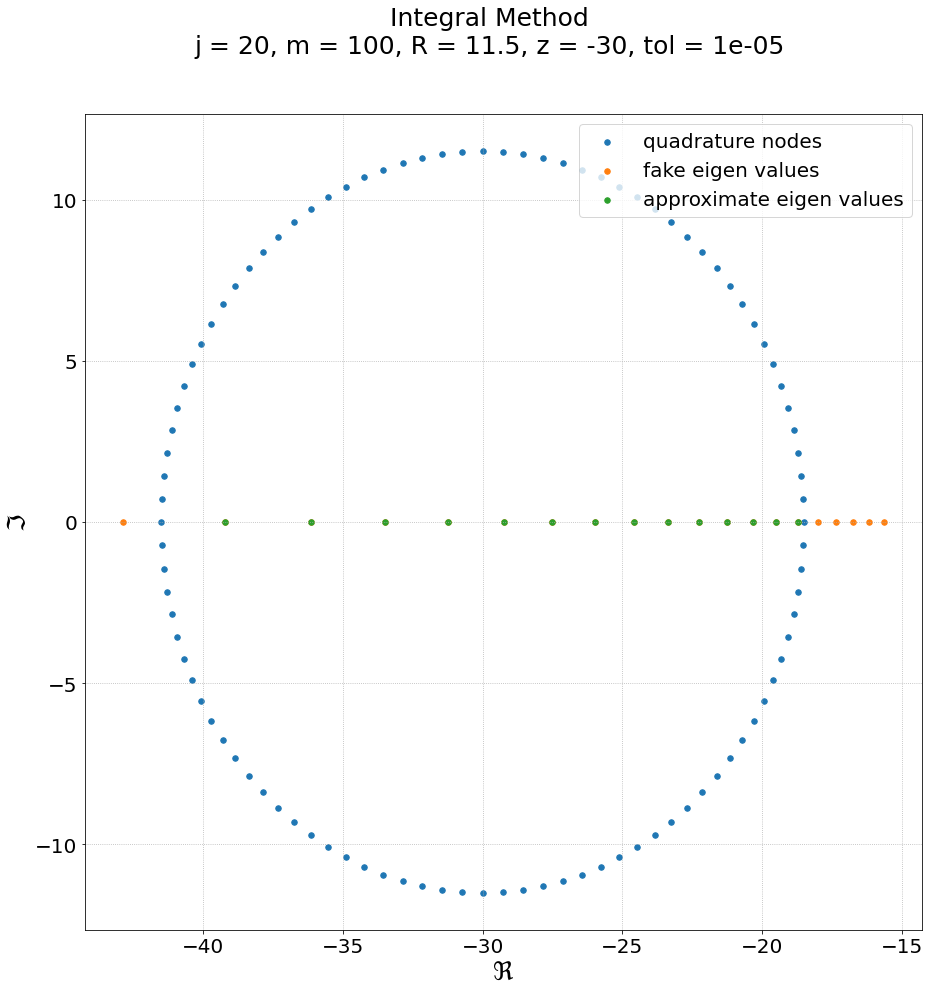

In [7]:
title = 'Integral Method' + '\n' + f'j = {j}, m = {m}, R = {R}, z = {z}, tol = {tol}'
legend = ('quadrature nodes', 'fake eigen values', 'approximate eigen values')

plot_complex(
    [quadrature_nodes, eigen_values_fake, eigen_values_approx],
    title, legend,
    markers_size = 30
)

### Singulärwerte überprüfen

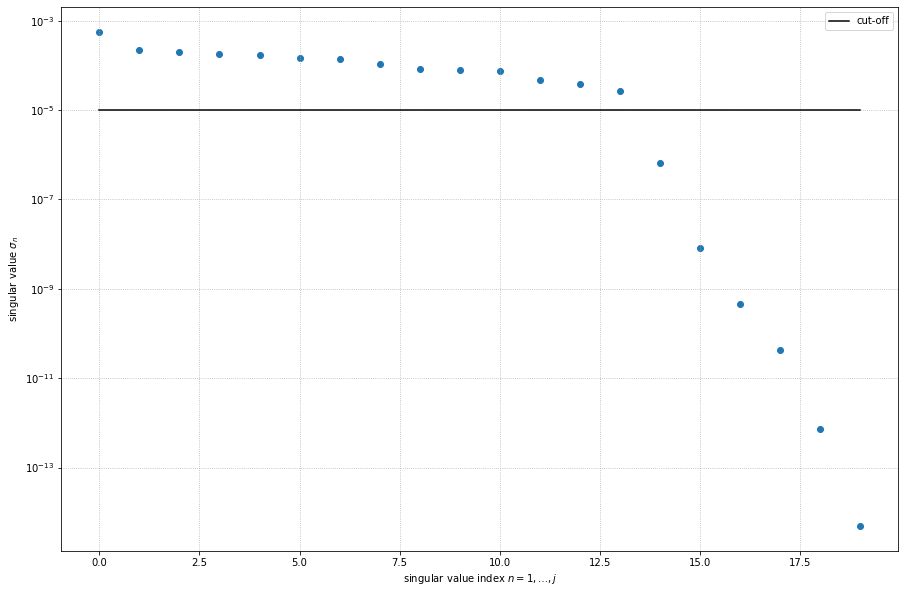

In [8]:
ax = plt.figure(figsize = (15, 10)).gca()

singular_value_indices = range(len(sigma_full))

ax.scatter(
    singular_value_indices,
    sigma_full
)

ax.plot(
    singular_value_indices,
    [tol] * len(singular_value_indices),
    color = 'black',
    label = 'cut-off'
)

ax.set_xlabel('singular value index $n = 1, \dots, j$')
ax.set_ylabel('singular value $\sigma_n$')
ax.set_yscale('log')
ax.legend()
ax.grid(linestyle = ':')

plt.show()

### Eigenwerte überprüfen

Wir bekommen also scheinbar tatsächlich $14$ "echte" Eigenwerte (über der Abtrennung).

Eine Heuristik, um Eigenwerte $\lambda$ zu identifizieren, d.h. ob $A(\lambda)$ singulär ist, besteht darin, die Konditionszahl zu betrachten.
Wenn diese sehr groß wird, dann ist $A(\lambda)$ (fast) singulär.

[-42.89049872-2.39039174e-09j -39.22119716+5.59715073e-14j
 -36.13367282+8.15376888e-14j -33.50150454-4.40285640e-15j
 -31.22999292-1.46954507e-14j -29.25099964-9.51715669e-14j
 -27.51085262-1.81042575e-14j -25.96967142-7.23965240e-15j
 -24.59477369-1.87728208e-14j -23.36130486-9.91086803e-14j
 -22.24822482-3.55623820e-14j -21.23925788+9.91742812e-15j
 -20.32024348-1.00962318e-15j -18.70891106+8.42290069e-15j
 -19.48008878-6.95153348e-15j -17.99889624-3.59194556e-12j
 -17.34293562-2.73138548e-13j -16.17095317-1.68260415e-06j
 -15.64543247-1.00947691e-04j -16.73537028-1.85740131e-08j]
[763653849803.8895, 2.4686459997629e+16, 5.428299028633203e+16, 2.9923498196652616e+16, 8.435055952339005e+16, 4.2068367069578264e+16, 2.714469000568957e+17, 1.0810006831309938e+17, 1.4170773397545418e+17, 8.51386348520423e+16, 2.3546302563895546e+17, 6.46520130757906e+16, 8.434480977974728e+16, 8.934658913954394e+16, 1.0259932639219184e+17, 3409349749921565.0, 29377762165335.965, 7859408931.012653, 138284

NameError: name 'eigen_value_indices' is not defined

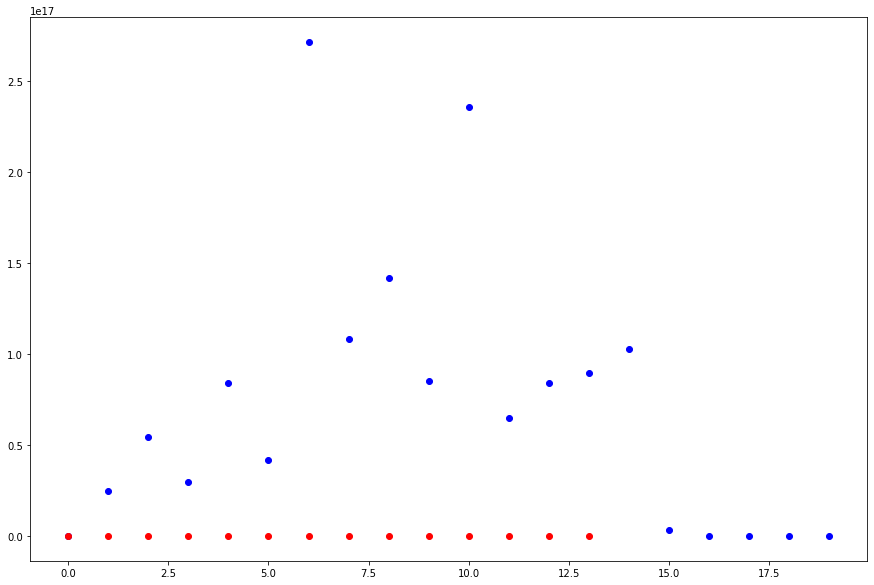

In [9]:
ax = plt.figure(figsize = (15, 10)).gca()

print(eigen_values_fake)
print([np.linalg.cond(T(ref)) for ref in eigen_values_fake])
print(eigen_values_approx)
print([np.linalg.cond(T(ref)) for ref in eigen_values_approx])

ax.scatter(
    range(len(eigen_values_fake)),
    [np.linalg.cond(T(ref)) for ref in eigen_values_fake], color = "b"
)

ax.scatter(
    range(len(eigen_values_approx)),
    [np.linalg.cond(T(ref)) for ref in eigen_values_approx], color = "r"
)

ax.plot(
    eigen_value_indices,
    [1e15] * len(eigen_value_indices),
    color = 'black',
    label = 'cut-off'
)

ax.set_xlabel('eigen value index $n = 1, \dots, k$')
ax.set_ylabel('condition number $\operatorname{cond} \, A(\lambda_n)$')
ax.set_yscale('log')
ax.legend()
ax.grid(linestyle = ':')

plt.show()

Wir bekommen also scheinbar tatsächlich $14$ "echte" Eigenwerte (über der Abtrennung).

## Lokale Testläufe

Wir verschärfen unsere ursprüngliche Approximationen an die Eigenwerte von $T$.
Dazu wenden wir nochmals `integral_method` an, mit diesen als Kreis-Mittelpunkt und kleinerem Radius.

In [18]:
# ---------------------------------------------------------------- #

# we expect only 1 eigen_value,
# take 2 random columns for safety
j = 2

# take 200 quadrature nodes for safety
m = 200

# choose smaller radius to isolate eigen-values
R = 0.5
# the center point will be each eigen value

# choose same tolerance as before
tol = 1e-5

# ---------------------------------------------------------------- #

eigen_values_ref = np.array([
    integral_method(T, N, j, m, R, eigen_value_approx, tol)[0]
    for eigen_value_approx in eigen_values_approx
])

# ---------------------------------------------------------------- #

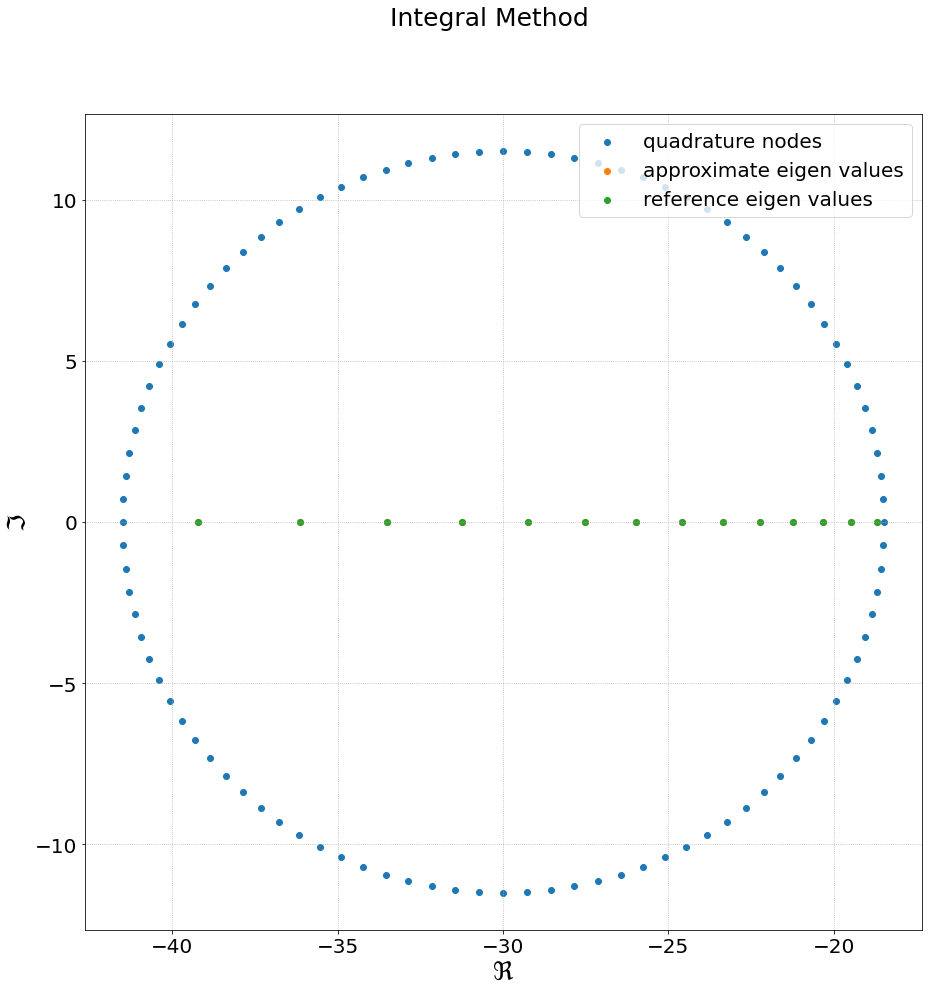

In [19]:
title = 'Integral Method'
legend = ('quadrature nodes', 'approximate eigen values', 'reference eigen values')

plot_complex(
    [quadrature_nodes, eigen_values_approx, eigen_values_ref],
    title,
    legend
)

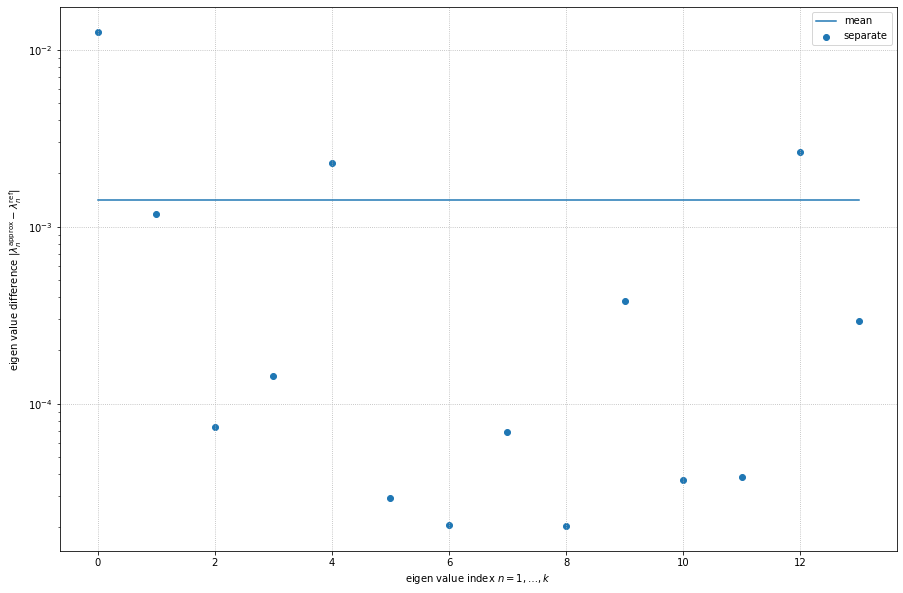

In [21]:
ax = plt.figure(figsize = (15, 10)).gca()

eigen_value_differences = abs(eigen_values_approx - eigen_values_ref)
eigen_value_indices = range(len(eigen_value_differences))

ax.scatter(
    eigen_value_indices,
    eigen_value_differences,
    label = 'separate'
)

ax.plot(
    eigen_value_indices,
    [sum(eigen_value_differences) / len(eigen_value_differences)] * len(eigen_value_indices),
    label = 'mean'
)

ax.set_yscale("log")
ax.set_xlabel('eigen value index $n = 1, \dots, k$')
ax.set_ylabel('eigen value difference $|\lambda_n^{\mathrm{approx}} - \lambda_n^{\mathrm{ref}}|$')
ax.legend()
ax.grid(linestyle = ':')

plt.show()

## Konvergenzgeschwindigkeit in Abhängigkeit des gewählten Kreises

Gemäß der Analyse des Algorithmus erwarten wir eine umso schnellere Konvergenzgeschwindigkeit,
je weiter die Kurve über die wir integrieren vom nächsten Eigenwert entfernt ist.

In [39]:
# ---------------------------------------------------------------- #

# recall initial settings ...
j = 20
z = -30
tol = 1e-5

# some auxilliary parameters
R_offset_array = np.array([0, 0.01, 0.1])
R_max = max(abs(z - eigen_values_ref))

# ... and add the rest
m_array = [5, 10, 15, 20, 50, 75, 100]
R_array = R_max - R_offset_array

# ---------------------------------------------------------------- #

error_arrays = [
    [
        max([
            min([
                np.abs(eigen_value_approx - eigen_value_ref)
                for eigen_value_ref in eigen_values_ref
            ])
            for eigen_value_approx in integral_method(T, N, j, m, R, z, tol)
        ])
        for m in m_array
    ]
    for R in R_array
]

# ---------------------------------------------------------------- #

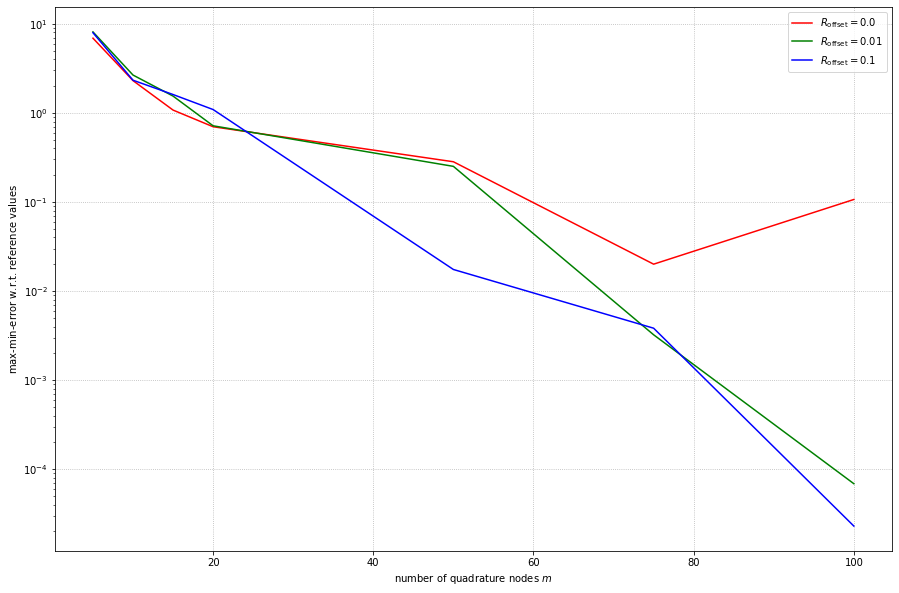

In [40]:
ax = plt.figure(figsize = (15, 10)).gca()

for error_array, R_offset, color in zip(error_arrays, R_offset_array, ['r', 'g', 'b']):
    ax.semilogy(
        m_array,
        error_array,
        color,
        label = '$R_\mathrm{offset} =' + ' ' + str(R_offset) + ' ' + '$'
    )

ax.set_xlabel('number of quadrature nodes $m$')
ax.set_ylabel('$\max$-$\min$-error w.r.t. reference values')

ax.legend()
ax.grid(linestyle = ':')

plt.show()

## Pitfalls

### 1. Zu ungenaue Quadratur

Wenn wir zu wenige Quadraturknoten wählen, fehlt uns die notwendige Genauigkeit um die
"korrekten" Singulärwerte zielsicher von den zusätzlichen Werten zu trennen.

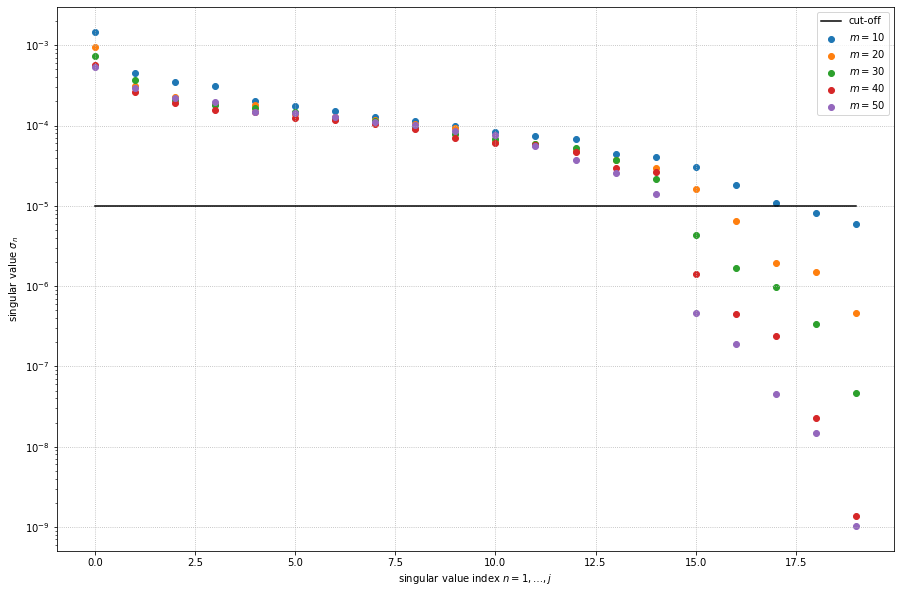

In [22]:
# ---------------------------------------------------------------- #

# recall initial settings ...
j = 20
R = 11.5
z = -30
tol = 1e-5

# ... and the rest
m_array = [10, 20, 30, 40, 50]

# ---------------------------------------------------------------- #

ax = plt.figure(figsize = (15, 10)).gca()

for m in m_array:

    debug_dict = integral_method(T, N, j, m, R, z, tol, debug = True)
    sigma_full = debug_dict['Sigma_full']
    singular_value_indices = range(len(sigma_full))

    ax.scatter(
        singular_value_indices,
        sigma_full,
        label = f'$m = {m}$'
    )

ax.plot(
    singular_value_indices,
    [tol] * len(singular_value_indices),
    color = 'black',
    label = 'cut-off'
)

ax.set_xlabel('singular value index $n = 1, \dots, j$')
ax.set_ylabel('singular value $\sigma_n$')
ax.set_yscale('log')
ax.legend()
ax.grid(linestyle = ':')

plt.show()

# ---------------------------------------------------------------- #

### 2. Zu kleine Zufalls-Matrix

C:\Users\richa\Dropbox\GitHub\Fundament-Mathematik\WS_2020-21\SemNumLinAlg\Nichtlineare Eigenwertprobleme\Code\outsource.py:137: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


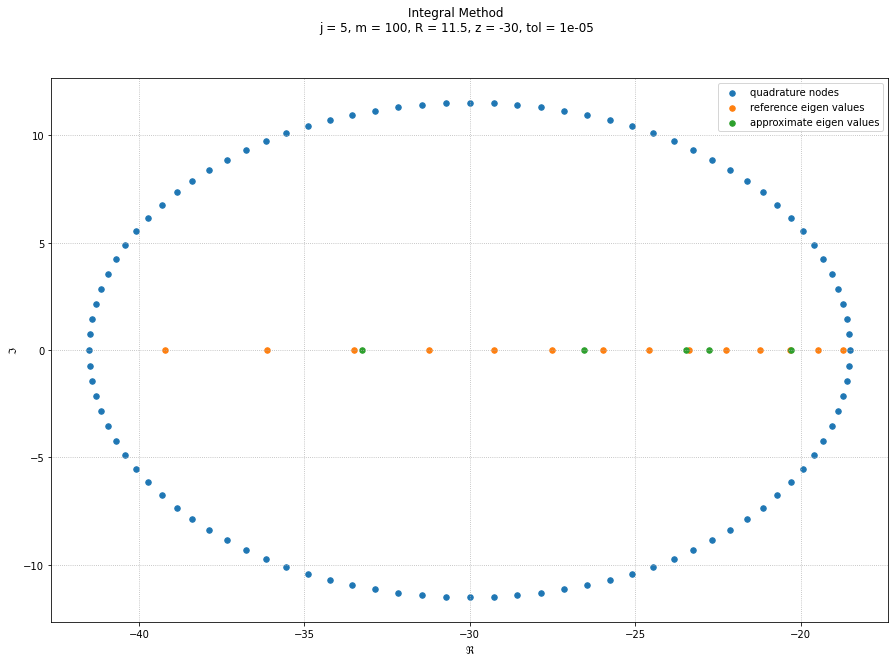

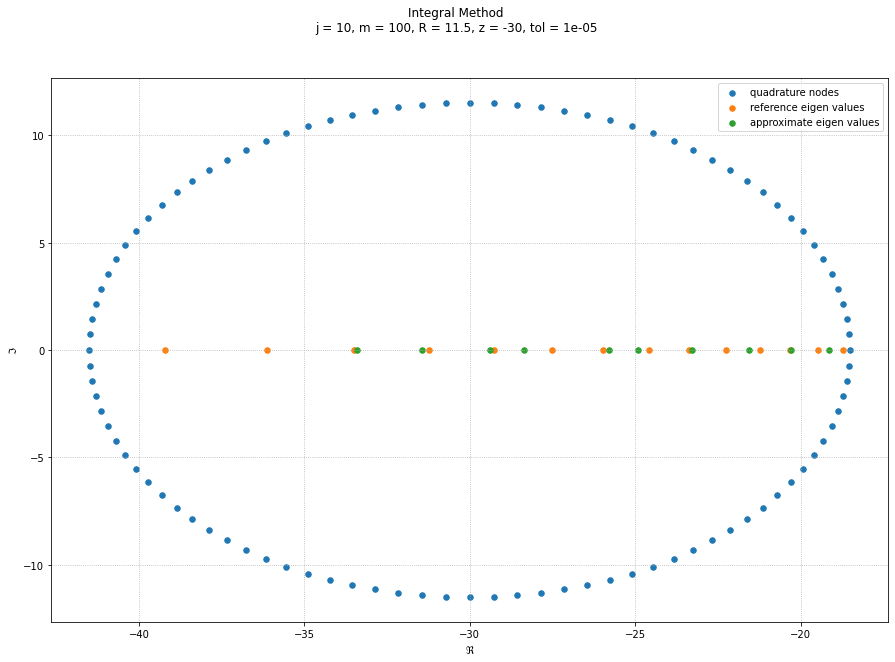

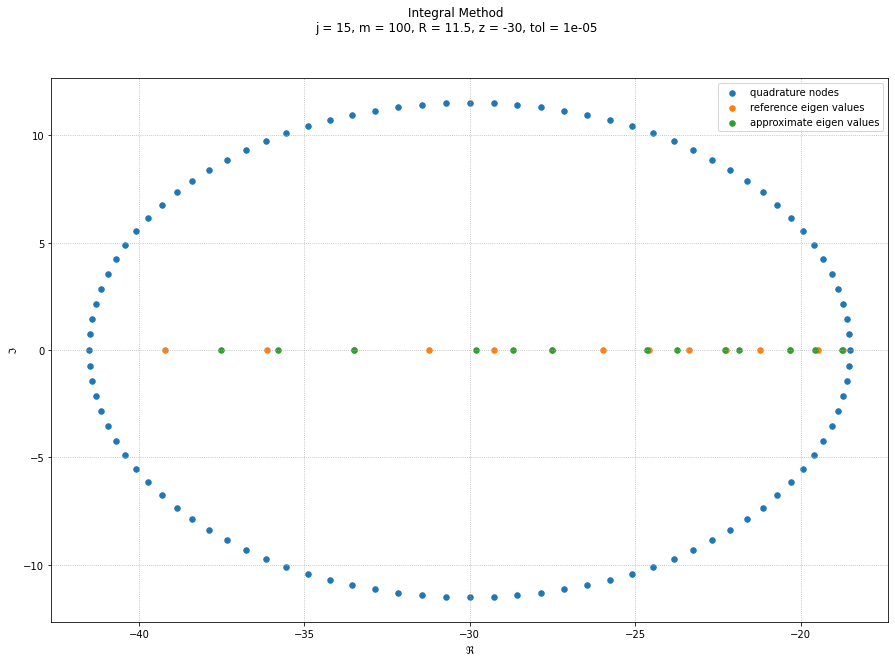

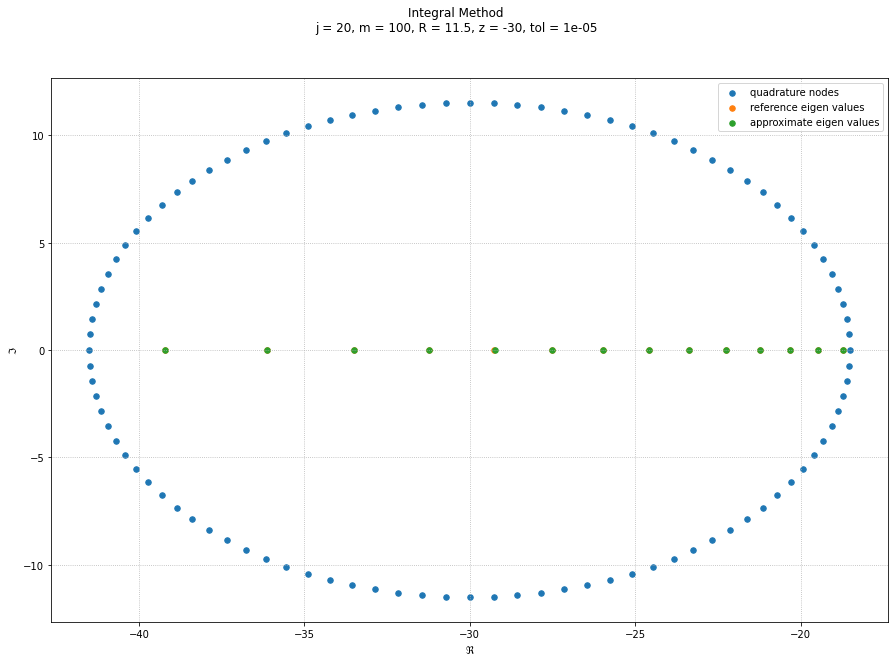

In [23]:
# ---------------------------------------------------------------- #

# recall initial settings ...
m = 100
R = 11.5
z = -30
tol = 1e-5

# ... and the rest
j_array = [5, 10, 15, 20]

# ---------------------------------------------------------------- #

for j in j_array:

    title = 'Integral Method' + '\n' + f'j = {j}, m = {m}, R = {R}, z = {z}, tol = {tol}'
    legend = ('quadrature nodes', 'reference eigen values', 'approximate eigen values')

    eigen_values_approx = integral_method(T, N, j, m, R, z, tol)

    plot_complex(
        [quadrature_nodes, eigen_values_ref, eigen_values_approx],
        title,
        legend,
        markers_size = 30
    )

# ---------------------------------------------------------------- #